# Analysis Work Flow of Nucleus Segmentation, Tracking and Visualization 

This notebook contains the workflow for tracking Cell nucelus protein binding intensities and geometries (e.g. Volume) in time-lapse movie.

Key steps of the workflows:

* Auto-Contrast intensity normalization
* 3D Gaussian smoothing 
* Masked-object Thresholding
* Watershed to remove merged objects
* Using trackpy to link frames
* Visualize segmentation and tracking results
* Plotting volume and protein binding changes as a function of time 
* Export data and statistics table



## Loading Required Libraries

In [23]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, binary_closing, ball, disk, erosion, dilation   # function for post-processing (size filter)
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import get_middle_frame, get_3dseed_from_mid_frame
from skimage import transform, measure
import h5py
from tqdm import tqdm
from pandas import DataFrame
import pandas as pd
import warnings
import h5py
from skimage.segmentation import watershed
from skimage.morphology import dilation, ball
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from aicssegmentation.core.utils import hole_filling
import trackpy as tp

## Loading Data, loading Visualization Platform and make some background functions

In [2]:
FILE_NAME = "Z://Niethammer Lab//Joe//Research Project//Cell Swelling Experiment//20201105 Cell Swelling Experiment//20201105 A549 cPla2 C2 Alox12 80% shock 1um Iono_1.hdf5"
f = h5py.File(FILE_NAME, 'r')

image = f['561 Channel'][:]


In [3]:
import napari
%gui qt

In [4]:
#Make a mask to clear border
from skimage.segmentation import clear_border
mask = np.ones(image[0].shape)

for n in range(mask.shape[0]):
   im_slice = mask[n,:,:]
   im_slice[0,:] = 0
   im_slice[:,0] = 0
   im_slice[:,-1] = 0
   im_slice[-1,:] = 0

mask = mask.astype(np.bool)


In [5]:
# Make a function to get middle frame based on segmented area
def get_middle_frame_area(labelled_image_stack):
    max_area = 0
    max_n = 0
    for z in range(labelled_image_stack.shape[0]):
       img_slice = labelled_image_stack[z,:,:]
       area = np.count_nonzero(img_slice)
       
       if area >= max_area:
          max_area = area
          max_n = z
    
    return max_n

## Make the 3D Cell Segmentation Pipeline 

This segmentation pipeline has two parts. The first part is image normalization and smoothing. The second part is image segmentation

* First Part: We first apply intensity normalization and 3D Gaussian Smooth on one time point. Then we propagate to all time points. Both functions are developed by Allen Institute Segmenter. <br /> <br /> 
Link: https://github.com/AllenInstitute/aics-segmentation
<br /> <br /> 
* Second Part: We first apply Mask-Object thresholding (MO) and Watershed on one time point. In brief, MO algorithm firstly applies low threshoding (e.g. median thresholding) to roughly mask out each object. Then apply high thresholding (e.g. Ostu thresholding) within each individual object. This way it can account intensity varaiation from cell to cell. Watershed here is to seperate falsely merged object. Both algorithms are developed by Allen Segmenter. Then we propogate to all time points. 



In [6]:
# Initiate the cell segmentation class
from skimage import filters
class cell_segment:
    def __init__ (self, Time_lapse_image, intensity_scaling_param = [40000], gaussian_smoothing_sigma = 1 ):
        self.image = Time_lapse_image.copy()
        self.Time_pts = Time_lapse_image.shape[0]
        
        self.normalization_param = intensity_scaling_param
        self.smooth_param = gaussian_smoothing_sigma
        
        self.structure_img_smooth = np.zeros(self.image.shape, dtype = np.float64)
        self.structure_img = np.zeros(self.image.shape, dtype = np.float64)
        self.segmented_object_image = np.zeros(self.image.shape, dtype = np.uint8)
        
        self.watershed_map_list = np.zeros(self.image.shape, dtype = np.uint8)
        self.seed_map_list = np.zeros(self.image.shape, dtype = np.uint8)
        
        
    # define a function to apply normalization and smooth on Time lapse images
    def img_norm_smooth (self):
        for t in tqdm(range(self.Time_pts)):
            img = self.image[t].copy()
            self.structure_img[t] = intensity_normalization(img, scaling_param=self.normalization_param)
            self.structure_img_smooth[t] = image_smoothing_gaussian_3d(self.structure_img[t], sigma=self.smooth_param)
        
   # define a function to apply Masked Object thresholding followed by seed-based watershed to each time point
    def MO_threshold_Time (self):
        for t in tqdm(range(self.Time_pts)):
            bw, object_for_debug = MO(self.structure_img_smooth[t], global_thresh_method='ave', object_minArea=10000, return_object=True,extra_criteria=True)
            bw = hole_filling(bw, 1, 5000, fill_2d=True)
            mid_z = get_middle_frame(bw, method='intensity')
            bw_mid_z = bw[mid_z,:,:]
            seed = get_3dseed_from_mid_frame(bw_mid_z, bw.shape, mid_z, hole_min=3000,bg_seed=False)
            watershed_map = -1*distance_transform_edt(bw)
            seg = watershed(watershed_map, markers=label(seed), mask=bw, watershed_line=True)
            seg = clear_border(seg, mask = mask)
            
            seg = remove_small_objects(seg>0, min_size=10000, connectivity=1, in_place=False)
            seg = hole_filling(seg, 1, 40000, fill_2d=True)
            #final_seg = segmentation_quick_view(seg)
            
            final_seg = label(seg)
            
            self.segmented_object_image[t] = final_seg
            self.watershed_map_list[t] = watershed_map
            self.seed_map_list[t] = seed
        

## 3D Cell Segmentation in Timelapse

In [7]:
track = cell_segment(image)
track.img_norm_smooth()
track.MO_threshold_Time()


100%|██████████████████████████████████████████| 70/70 [09:29<00:00,  8.13s/it]


In [8]:
viewer = napari.Viewer()
viewer.add_image(image, scale = [1,5,1,1])
viewer.add_image(track.segmented_object_image>0 ,name='Segmented Object', scale = [1,5,1,1])
peaks = np.nonzero(track.seed_map_list)
viewer.add_points(np.array(peaks).T, name='peaks', size=5, face_color='red',scale=[1,5,1,1]);

## Quantify Nucleus Geometry (e.g. Volume) and Protein binding over time
<br /> 
**Cell_attribute class has two parts. The first part is to 3D smooth the image stack that needs to be quantified for protein binding. The second part is to make a table that store all information (e.g. Volume, Protein binding).**

In [43]:
# Initiate the cell attribute class

class cell_attribute:
    def __init__ (self, segmented_image_seq, intensity_image_stack, smooth_sigma = 1.0):
        self.labeled_stack = segmented_image_seq
        self.positions_table = None
        self.intensity_image_stack_raw = intensity_image_stack
        self.intensity_image_stack = np.zeros(intensity_image_stack.shape)
        self.labeled_stack_modify = self.labeled_stack.copy()
        self.smooth_sigma = smooth_sigma
        self.mid_slice_stack = np.zeros(intensity_image_stack.shape)
    # Function to 3D gaussian smooth intesnity image stack
    def intensity_stack_smooth (self):
        for t in tqdm(range(self.intensity_image_stack.shape[0])):
          img = self.intensity_image_stack_raw[t].copy()
          self.intensity_image_stack[t] = image_smoothing_gaussian_3d(img, sigma=self.smooth_sigma)
            
    # function to create pandas table of cell attributes without tracking info
    def create_table_regions(self):

        positions = []

        for n in tqdm(range(0,self.labeled_stack.shape[0])):
            labeled_slice = self.labeled_stack[n]
    
            for region in measure.regionprops(labeled_slice):
                position = []

                z_pos = region.centroid[0]
                y_row = region.centroid[1]
                x_col = region.centroid[2]

                volume = region.area * (0.19*0.19*1)

                nucleus_image = labeled_slice == region.label
                mid_z = get_middle_frame_area(nucleus_image)
                
                mid_nucleus_image = nucleus_image[mid_z,:,:]
                
                segmented_image_shell= np.logical_xor(mid_nucleus_image,erosion(mid_nucleus_image, selem=disk(6)))
                 
                
                label = region.label
                intensity_single = self.intensity_image_stack[n]
                intensity_image = intensity_single[mid_z]
                intensity_median = np.median(intensity_image[segmented_image_shell==True])

                intensity_background = np.median(self.intensity_image_stack[n][int(mid_z),int(y_row),int(x_col)])

                intensity_median_ratio = intensity_median / intensity_background

                position.append(x_col)
                position.append(y_row)
                position.append(z_pos)
                position.append(int(n))
                position.append(label)


                position.append(volume)
                #position.append(surface_area_actual)
                position.append(intensity_median_ratio)

                positions.append(position)
                
                self.mid_slice_stack[n,mid_z,:,:] += segmented_image_shell
                self.mid_slice_stack[n,mid_z,int(y_row),int(x_col)] = 1
                
        self.positions_table  = DataFrame(positions, columns = ['x','y','z',"frame",'label','volume', 'median intensity ratio'])

    

    

## Store attributes in table

In [44]:
Segment_tracker = cell_attribute(track.segmented_object_image,image)
Segment_tracker.intensity_stack_smooth()
Segment_tracker.create_table_regions()

100%|██████████████████████████████████████████| 70/70 [00:30<00:00,  2.27it/s]


## Look at the table
<br />

**x: x coordinate of centroid**
<br />

**y: y coordinate of centroid**
<br />

**z: z coordinate of centroid**
<br />

**frame: frame number in the time lapse**
<br />

**label: object ID generated by segmentation (It is not tracking ID)**
<br />

**volume: object volume in um^3**
<br />

**median intensity ratio: The intensity of object(cell) rim / intensity of centroid**

In [45]:
# Have a look at the table
table= Segment_tracker.positions_table


table.head()

,x,y,z,frame,label,volume,median intensity ratio
0,340.587434,148.836281,5.341885,0,1,1839.1867,0.803965
1,150.941229,198.194205,5.889776,0,2,1573.7073,1.068565
2,293.432128,273.572826,5.795461,0,3,1719.5874,0.782198
3,340.192583,148.802385,5.788964,1,1,1807.5992,0.837488
4,150.714541,198.939607,6.131501,1,2,1613.9227,1.030524


## Linking Frames in Time-Lapse Movie

* Use Trackpy to track and link consecutive frames. Remove tracks that does not meet minimum frames
* Add another **particle** column to record tracking ID

In [61]:
# Link cells between frames
Labelled_table = tp.link_df(Segment_tracker.positions_table, 15,adaptive_stop=1, adaptive_step=2, memory=3,pos_columns=['x', 'y', 'z'])

#Filter out tracks with low number of frames
Labelled_table = tp.filter_stubs(Labelled_table, 60)

Labelled_table

Frame 69: 3 trajectories present.


,x,y,z,frame,label,volume,median intensity ratio,particle
frame,,,,,,,,
0,340.587434,148.836281,5.341885,0,1,1839.1867,0.803965,0
0,150.941229,198.194205,5.889776,0,2,1573.7073,1.068565,1
0,293.432128,273.572826,5.795461,0,3,1719.5874,0.782198,2
1,340.192583,148.802385,5.788964,1,1,1807.5992,0.837488,0
1,150.714541,198.939607,6.131501,1,2,1613.9227,1.030524,1
...,...,...,...,...,...,...,...,...
68,348.550197,138.355015,6.320616,68,1,2125.1348,0.809945,0
68,291.971954,259.952895,6.645768,68,3,2197.1904,0.930663,2
69,139.743351,196.803056,6.403103,69,2,1856.8396,0.933209,1


### Normalize protein binding intensity ratio and add the "normalized intensity ratio" column to table

In [58]:
Labelled_table['normalized intensity ratio'] = Labelled_table['median intensity ratio']

all_labels = Labelled_table.particle.unique()

for label in all_labels:
   Labelled_table['normalized intensity ratio'][Labelled_table.particle ==label] = Labelled_table['normalized intensity ratio'][Labelled_table.particle ==label]/Labelled_table['median intensity ratio'][Labelled_table.particle ==label][0]





C:\Users\joeshen\Anaconda3\envs\guv_pipeline\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
#Add tracks

Labelled_table.rename(columns = {'frame':'time'}, inplace = True)
Labelled_table.particle += 2
Labelled_table
table_rev = Labelled_table[['particle','time','z','y','x']]

Labelled_table
a=table_rev.sort_values(by=['particle','time'])

c = a.to_numpy()
c

array([[  2.        ,   0.        ,   5.3418847 , 148.83628084,
        340.587434  ],
       [  2.        ,   1.        ,   5.78896389, 148.80238457,
        340.19258268],
       [  2.        ,   2.        ,   5.72385092, 148.82109232,
        339.76204701],
       ...,
       [  4.        ,  67.        ,   6.6542892 , 259.90444598,
        291.61598508],
       [  4.        ,  68.        ,   6.64576761, 259.95289498,
        291.97195386],
       [  4.        ,  69.        ,   6.51362581, 259.28165996,
        291.97817908]])

### Make a function to modify segmentation masks and color the object based on ID. The object that does not meet minimum frames will be deleted

In [16]:
#function to modify segmented images based on label tracks ID. Remove objects that only exist in a few frames 
def segmented_image_final_processing (tables, labelled_image):
    new_labelled_image = np.zeros(labelled_image.shape)
    for t in tqdm(range(0,tables.frame.max()+1)):
        
       Position_table_t = tables[tables.frame == t]
       original_label = Position_table_t.label.to_list() 
       original_label = [x*1000 for x in original_label]
       new_label = Position_table_t.particle.to_list() 
       new_label = [x+1 for x in new_label]
       
       label_convert = list(zip(original_label, new_label))
            
       labelled_image_t = labelled_image[t].copy() * 1000
       
       for num in np.unique(labelled_image_t):
          if num != 0 and num not in original_label:
             labelled_image_t[labelled_image_t == num] = 0
       
       for element in label_convert:
          original = element [0]
          new = element [1] 
          labelled_image_t[labelled_image_t == original] = new

       new_labelled_image[t] = labelled_image_t
            
    return new_labelled_image
                
            

            


In [17]:
# Change images based on new labels

labelled_segmented_image = segmented_image_final_processing(Labelled_table, track.segmented_object_image)

100%|██████████████████████████████████████████| 70/70 [00:25<00:00,  2.73it/s]


## Visualize in Napari

In [63]:
# Visualize Final Result
viewer = napari.Viewer()
viewer.add_image(image, scale = [1,5,1,1])
viewer.add_image(Segment_tracker.mid_slice_stack,name='Mid Plane', scale = [1,5,1,1])
#viewer.add_labels(labelled_segmented_image, name='Segmentation with ID', scale=[1,5,1,1])
viewer.add_tracks(c,name="Tracks",scale=[1,5,1,1])
viewer.add_image(track.watershed_map_list,name='Distance Map', scale = [1,5,1,1])
viewer.add_image(track.segmented_object_image>0 ,name='Segmented Object', scale = [1,5,1,1])
peaks = np.nonzero(track.seed_map_list)
viewer.add_points(np.array(peaks).T, name='peaks', size=5, face_color='red',scale=[1,5,1,1]);

## Plot Data (e.g. Volume, Protein binding)


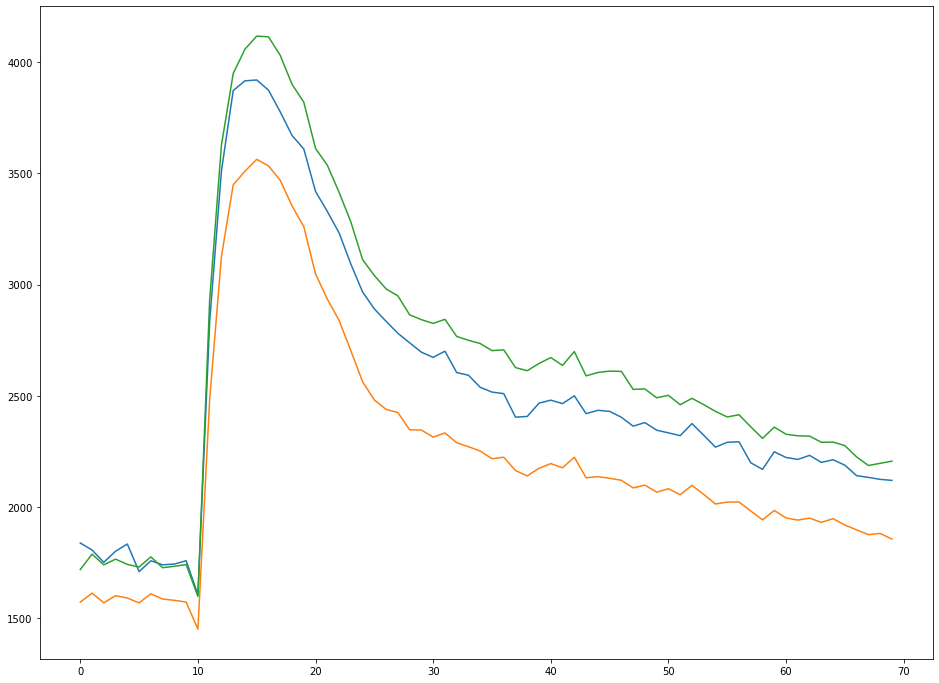

In [13]:
# Plot volume for all objects (cells)
all_labels = Labelled_table.particle.unique()

for label in all_labels:
   df_subset = Labelled_table[Labelled_table.particle == label]
   plt.plot(df_subset["frame"],df_subset["volume"])

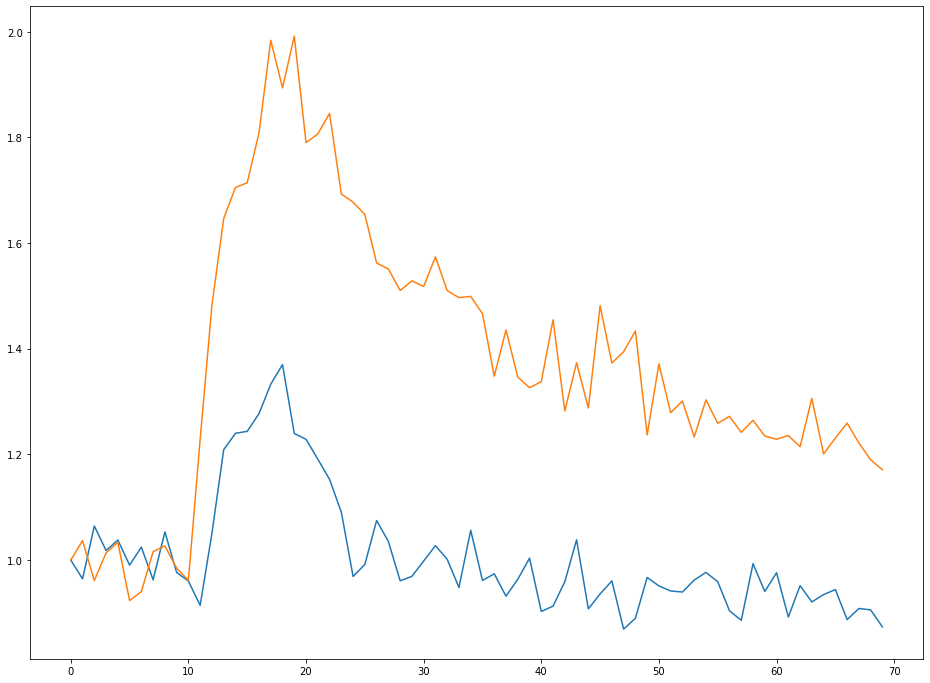

In [34]:
# Plot normalized intensity for all objects (cells)
all_labels = Labelled_table1.particle.unique()

for label in all_labels:
   df_subset = Labelled_table1[Labelled_table1.particle == label]
   plt.plot(df_subset["frame"],df_subset["normalized intensity ratio"])

In [33]:
#Labelled_table1 = Labelled_table[Labelled_table[Labelled_table.particle == 0]]
Labelled_table1 = Labelled_table[Labelled_table.particle != 0]
#Labelled_table1

## Save data and table

In [71]:
# Save data to hdf5
File_save_names = '/Users/zhouyangshen/Desktop/Python_Nucleus_Segmentation/75_hypotonic_shock'
seg_save_name='{File_Name}_segmentation_result.hdf5'.format(File_Name = File_save_names)

with h5py.File(seg_save_name, "w") as f:
      f.create_dataset('Mid Plane', data = Segment_tracker.mid_slice_stack, compression = 'gzip')
      f.create_dataset('Segmented Object', data = track.segmented_object_image, compression = 'gzip')
      f.create_dataset('Segmentation with ID', data = labelled_segmented_image, compression = 'gzip')
      f.create_dataset('Distance Map', data = track.watershed_map_list, compression = 'gzip')
      f.create_dataset('Seed Map', data = track.seed_map_list, compression = 'gzip')
      f.create_dataset('Normalized and Smooth Image', data = track.structure_img_smooth, compression = 'gzip')


In [73]:
# Save table to csv
table_save_name = '{File_Name}_statistic_result.csv'.format(File_Name = File_save_names)

Labelled_table.to_csv(table_save_name,index=False)